In [ ]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

In [1]:
!pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)

[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [34]:
from os.path import join

import anndata
import scanpy as sc
import dask.dataframe as dd
import dask.array as da
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [3]:
cols = [
    'dataset_id', 
    'assay', 
    'cell_type', 
    'development_stage', 
    'disease', 
    'tissue', 
    'tissue_general', 
    'tech_sample'
]

obs_train = dd.read_parquet(join(PATH, 'train'), columns=cols, split_row_groups=True).compute()
obs_val = dd.read_parquet(join(PATH, 'val'), columns=cols, split_row_groups=True).compute()
obs_test = dd.read_parquet(join(PATH, 'test'), columns=cols, split_row_groups=True).compute()
obs = pd.concat([obs_train, obs_val, obs_test]).reset_index(drop=True)


cell_type_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/tissue_general.parquet'))
tissue_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/tissue.parquet'))
disease_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/disease.parquet'))
assay_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/assay.parquet'))

# Summary plot of data

In [5]:
len(obs)

22189056

In [6]:
obs.dataset_id.nunique()

249

In [7]:
obs.disease.nunique()

52

In [8]:
obs.cell_type.nunique()

164

In [9]:
obs.tissue_general.nunique()

56

In [10]:
obs.tech_sample.nunique()

5052

In [20]:
obs_plot = (
    obs[['tissue_general', 'cell_type', 'tech_sample']]
    .groupby(['tissue_general', 'cell_type'])['tech_sample']
    .nunique()
    .reset_index()
    .rename(columns={'tech_sample': 'n_donors'})
)
obs_plot

,tissue_general,cell_type,n_donors
0,0,0,5
1,0,22,5
2,0,54,5
3,0,63,5
4,0,74,5
...,...,...,...
1483,55,127,1
1484,55,129,1
1485,55,138,1
1486,55,142,1


In [12]:
n_donors_per_celltype = (
    obs[['cell_type', 'tech_sample']]
    .groupby('cell_type')['tech_sample']
    .nunique()
    .to_dict()
)

In [13]:
n_diseases_per_celltype = (
    obs[['cell_type', 'disease']]
    .groupby('cell_type')['disease']
    .nunique()
    .to_dict()
)

In [21]:
obs_plot['tissue_general'] = tissue_general_mapping.iloc[obs_plot.tissue_general].to_numpy()
obs_plot['cell_type'] = cell_type_mapping.iloc[obs_plot.cell_type].to_numpy()
obs_plot['n_donors_per_cell_type'] = obs_plot['cell_type'].replace(n_donors_per_celltype)
obs_plot['n_diseases_per_celltype'] = obs_plot['cell_type'].replace(n_diseases_per_celltype)

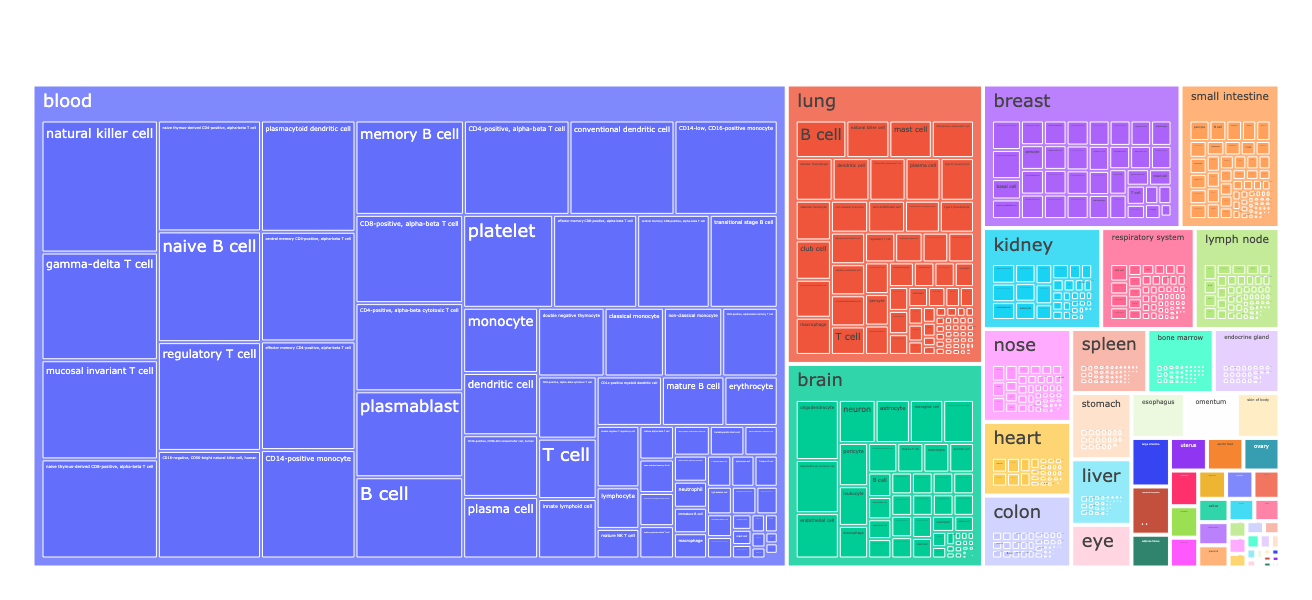

In [34]:
import plotly.express as px
import plotly.io as pio


fig = px.treemap(
    obs_plot, 
    path=['tissue_general', 'cell_type'],
    values='n_donors',
    # color='tissue_general'
)
fig.update_layout(
    width=600,   # Width of the figure in pixels
    height=600,  # Height of the figure in pixels
)
fig.update_layout(
    font={'size': 18},
    uniformtext=dict(minsize=12),
    margin = dict(t=50, l=25, r=25, b=25)
)
fig.update_layout(coloraxis_colorbar_title=None)
fig.update_traces(textinfo='label')
fig.show()
pio.write_image(fig, '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/data-summary-simple.png', scale=3)
pio.write_image(fig, '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/data-summary-simple.pdf')

# Distribution of donors with repect to unique cell types + number of cells

In [4]:
df = pd.DataFrame({
    'number of unique cell types per donor': obs[['tech_sample', 'cell_type']].groupby('tech_sample')['cell_type'].nunique(),
    'number of cells per donor': obs.tech_sample.value_counts().sort_index()
})
df

,number of unique cell types per donor,number of cells per donor
0,10,10074
1,3,7680
2,3,9680
3,2,4911
4,2,4236
...,...,...
5047,3,833
5048,3,791
5049,8,5727
5050,7,9761


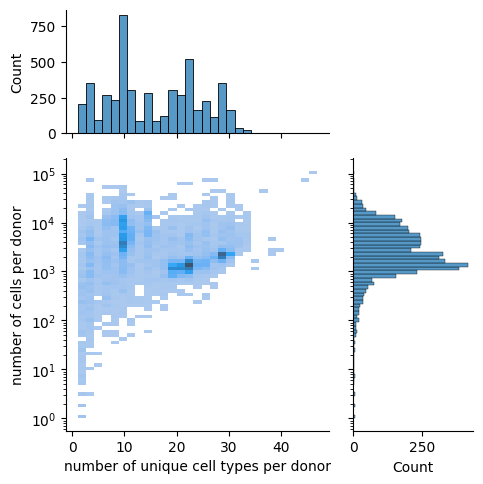

In [6]:
g = sns.jointplot(
    data=df, 
    x='number of unique cell types per donor', 
    y='number of cells per donor', 
    log_scale=(False, True), 
    kind='hist',
    ratio=2,
    height=5.,
    marginal_ticks=True
)

g.ax_joint.get_figure().savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/donor_distribution.pdf', format='pdf')
g.ax_joint.get_figure().savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/donor_distribution.png', format='png', dpi=300)

# Summary table

In [34]:
summary_table = (
    obs[['tissue_general', 'cell_type', 'tech_sample']]
    .groupby(['tissue_general', 'cell_type'])['tech_sample']
    .agg(['nunique', 'count'])
    .reset_index()
    .rename(columns={'tech_sample': 'n_donors', 'nunique': 'n_donors', 'count': 'n_cells'})
)
summary_table['tissue_general'] = tissue_general_mapping.iloc[summary_table.tissue_general].to_numpy()
summary_table['cell_type'] = cell_type_mapping.iloc[summary_table.cell_type].to_numpy()

summary_table[['cell_type', 'tissue_general', 'n_donors', 'n_cells']].sort_values(['cell_type', 'tissue_general'])

,cell_type,tissue_general,n_donors,n_cells
0,B cell,abdomen,5,384
8,B cell,abdominal wall,1,17
29,B cell,adrenal gland,2,68
37,B cell,ascitic fluid,25,3036
45,B cell,axilla,1,30
...,...,...,...,...
1198,vein endothelial cell,respiratory system,23,4748
1326,vein endothelial cell,small intestine,36,3166
1425,vein endothelial cell,stomach,25,983
1434,vein endothelial cell,tongue,2,217


In [35]:
(
    summary_table[['cell_type', 'tissue_general', 'n_donors', 'n_cells']]
    .sort_values(['cell_type', 'tissue_general'])
    .to_csv('supp_table_donors_and_cells_per_tissue+cell_type.csv')
)

# Shared cell types across tissues

In [60]:
import yaml

with open('shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

In [17]:
n_tissues_per_cell_type = obs[['cell_type', 'tissue_general']].groupby('cell_type')['tissue_general'].nunique()

In [22]:
assert np.all(n_tissues_per_cell_type.index == cell_type_mapping.index)
n_tissues_per_cell_type.index = cell_type_mapping.label

/tmp/ipykernel_2876651/2790738409.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


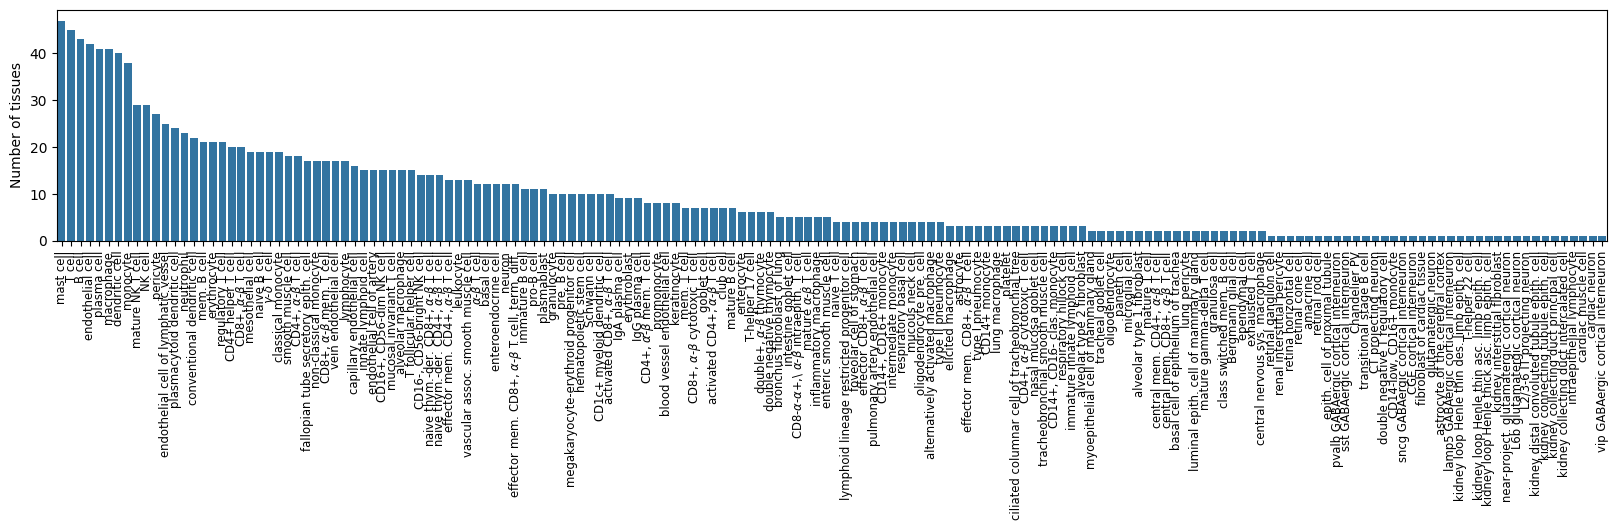

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))

sns.barplot(
    x='label',
    y='tissue_general',
    data=(
        n_tissues_per_cell_type
        .sort_values(ascending=False)
        .to_frame().reset_index()
        .assign(label=lambda df: df.label.replace(shortend_cell_types))
    ),
    ax=ax,
    color='#1f77b4'
)

ax.set_ylabel('Number of tissues')
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize='small')
plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/tissues_per_cell_type.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/tissues_per_cell_type.png')

In [80]:
(
    n_tissues_per_cell_type
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
    .rename(columns={'label': 'cell_type', 'tissue_general': 'number_of_tissues'})
    .to_csv('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/supp_table_number_of_tisses_for_each_cell_type.csv')
)

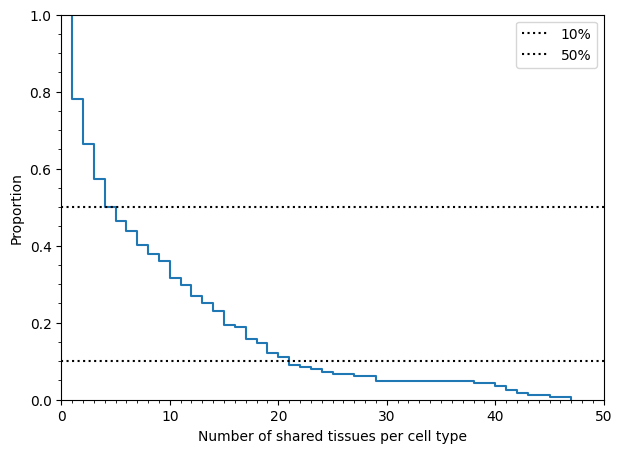

In [100]:
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax = sns.ecdfplot(
    x='tissue_general',
    data=n_tissues_per_cell_type.to_frame(),
    complementary=True
)
ax.set_xlim(0, 50)
ax.minorticks_on()
minor_locator = MultipleLocator(1.)  # Adjust the interval as needed
ax.xaxis.set_minor_locator(minor_locator)
ax.set_xlabel('Number of shared tissues per cell type')
ax.axhline(0.1, color='#000000', ls=':', label='10%')
ax.axhline(0.5, color='#000000', ls=':', label='50%')
ax.legend()

plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/ecdf_tissues_per_cell_type.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/ecdf_tissues_per_cell_type.png')